# Foundations of CNNs
First, a sample network:

In [1]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(
    32,
    (3, 3),
    activation = 'relu',
    input_shape = (28, 28, 1)
))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(
    64,
    (3, 3),
    activation = 'relu'
))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(
    64, 
    (3, 3),
    activation = 'relu'
))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

## Conv2D
* Input-Shape ist hier als 28px Breite, 28px Höhe, 1 Kanal (schwarz-weiß)
* Es ist zu sehen, dass nach einer Convolution-Schicht die Zahl der Dimensionen steigt, und die Höhe und Breite etwas sinken (Padding), weil 32 Filter auf dieses Bild angewandt werden
* nach Pooling-Schichten sinkt die  Höhe und Breite, da in diesen Falle immer 2 x 2 für jede Schicht zu 1 x 1 Felder gemacht werden
    * die Zahl der Kanäle bleibt beim Pooling erhalten
* Flatten ist für die Umgestaltung von 3px Breite * 3px Höhe * 64 Filtern in einen Vektor $3 * 3 * 64 = 576$ verantwortlich

In [15]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(train_X, train_y), (test_X, test_y) = mnist.load_data()

# besitzt keine explizit angegebene Dimension für Kanäle, daher reshape
print(train_X.shape, train_y.shape, type(train_X)) 
print(train_X[0]) # Werte von 0 bis 255, wie es bei Bildern üblich ist
train_X = train_X.reshape((60000, 28, 28, 1)) # expiliziter Kanal
train_X = train_X.astype('float32') / 255 # Nun Werte zwischen 0 und 1

test_X = test_X.reshape((10000, 28, 28, 1)) # expiliziter Kanal
test_X = test_X.astype('float32') / 255 # Nun Werte zwischen 0 und 1

print(train_y[0])
train_y = to_categorical(train_y) # one-hot encoding
test_y = to_categorical(test_y)
print(train_y[0])

model.compile(
    optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
model.fit(train_X, train_y, epochs = 5, batch_size = 64)

test_loss, test_acc = model.evaluate(test_X, test_y)
test_acc

W0727 16:25:39.485651 140150072796992 deprecation.py:323] From /home/dominik/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(60000, 28, 28) (60000,) <class 'numpy.ndarray'>
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0  

0.9923

## Convolution
Hier gleiten Filter über das Bild. Der Filter ist meist eine 3 mal 3 Matrix, die ein bestimmtes Muster (z.B. vertikalen Strich, siehe Bild) kodiert. Die Werte der Matrix werden mit den Werten der darutnerliegenden Pixel des jeweiligen Kanals multipliziert. Der daraus resultierende Skalar ist ein Wert der aussagt, wie sehr dieser Bildbereich dem Muster entspricht.
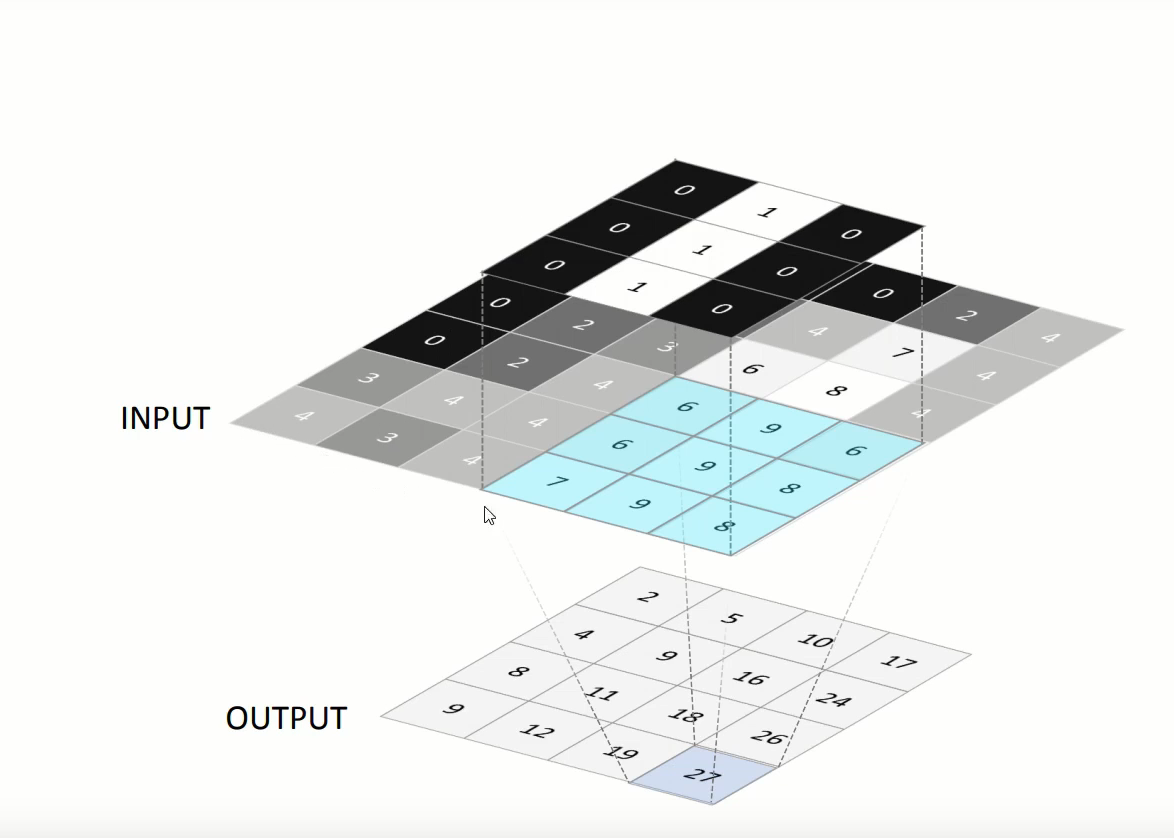
Ein Stride von 1 bedeutet, dass der Filter in jedem Schritt um einen Pixel weitergeschoben wird.
Die Response Map ist die Matrix der Bewertungen der Bildbereiche für einen bestimmten Kanal.
Werden auf diesen Response Maps wieder diese Operationen ausgeführt, lassen sich zunehmend komplexere Muster erkennen, die die dicht vernetzten Schichten lernen können.
Im Beispiel werden 32 Filter angewandt, woraus die neue Kanaldimension von 32 entsteht ($32$ Filter $* 1$ Kanal) .

Die Höhe und Breite sinken, weil der Filter nicht auf die Randpixel angewandt werden kann, weil sonst ein Teil des Filters über das Bild hinausragen würde. Wie groß der ignorierte Rand ist, lässt sich über `padding` in der `Conv2D` steuern.

Die Outputgröße wird zudem über `stride` gesteuert, was bestimmt, um wie viele Pixel der Filter springt.

## Max-Pooling
Hier wird dafür gesorgt, dass die Datenmenge wegen der größeren Zahl an Kanälen handhabbar bleibt. Max-Pooling verkleinert Höhe und Breite, indem es bspw. einen 2 mal 2 Fenster des Originalbildes zu seinem Maximalwert zusammenfasst. Die Größe dieses Fensters lässt sich im Konstruktor bestimmen. Ein weiterer Grund, das Bild zusammenzufassen ist es, Muster weiter oben in der Hierarchie zu lernen, was durch Max-Pooling begünstigt wird.